In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Sampling and aliasing

Something that should have been obvious so far is that the data we have been using are discrete. You can think of them as "samples" from a continuous underlying data. Here we examine the effect of sampling continuous data, in terms of the FFT, and in terms of trying to reconstruct a "true" continuous object from samples or samples of its FFT.

The most important fact about sampling is this: taking samples in real space is the same as repeating the Fourier transform periodically, and the period of repetition is the inverse of the sampling period. Read this again to make sure you understand it. Perhaps the picture below can help:

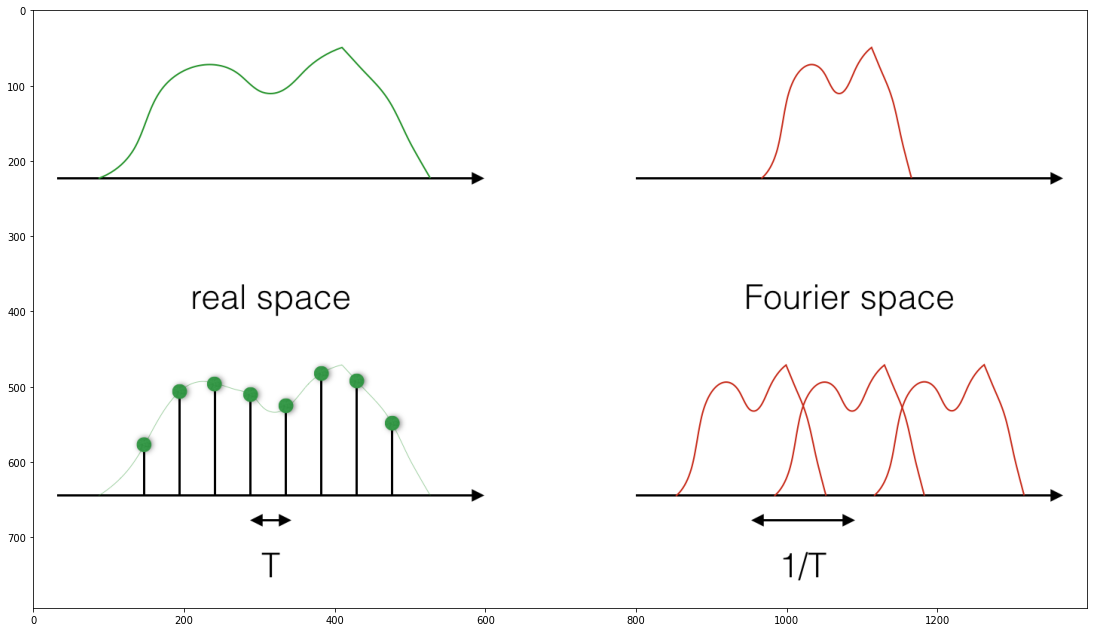

In [5]:
plt.figure(figsize=(20,11))
image = mpimg.imread("sampling.png")
imgplot = plt.imshow(image)
plt.show()

And the image below shows that it is also true the other way round:

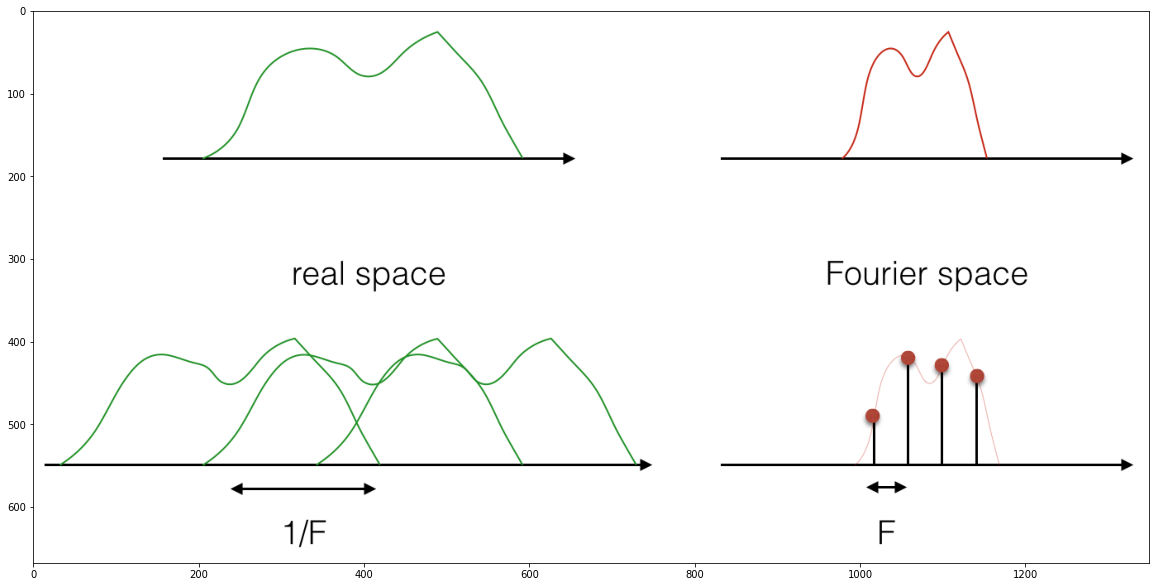

In [6]:
plt.figure(figsize=(20,11))
image = mpimg.imread("sampling2.png")
imgplot = plt.imshow(image)
plt.show()

Now, the above is true in general for the Fourier transform. But in signal processing and the world of discrete data, we are doing a discrete Fourier transform with the FFT. So in practice, both the real and the Fourier domains are given by samples. This means that they are both sampled, and they are both repeated! See the figure below:


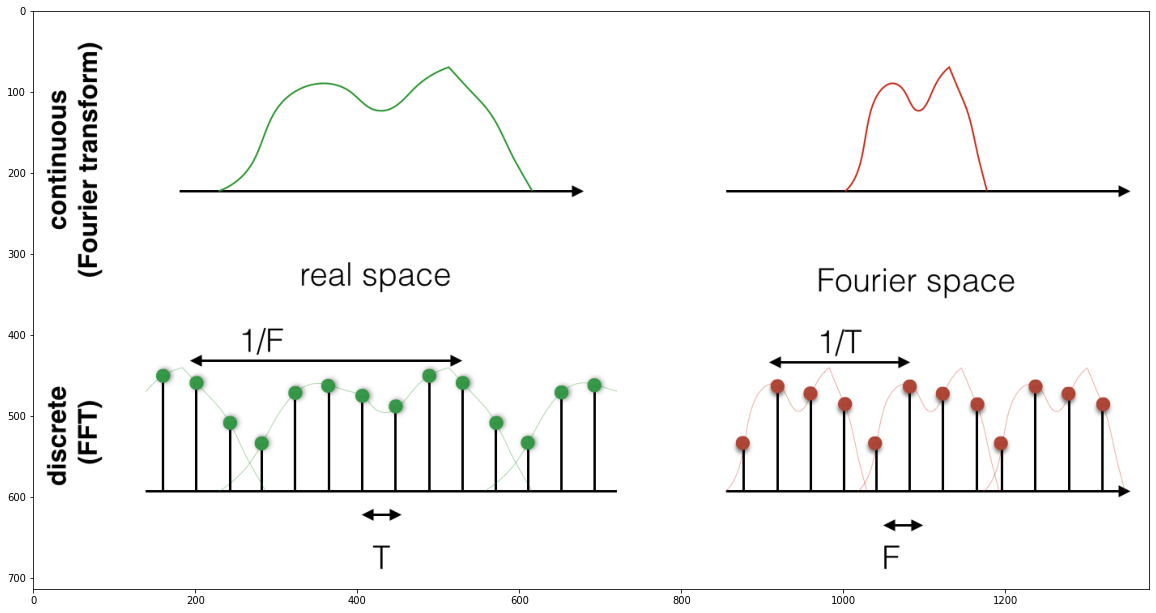

In [7]:
plt.figure(figsize=(20,11))
image = mpimg.imread("sampling3.png")
imgplot = plt.imshow(image)
plt.show()

Now, when you run an FFT in Numpy, the repeating pattern is not apparent. That is because the FFT algorithm implicitly considers the signal and its FFT to be periodic (i.e. repeating) and only gives you one period.

How does the above information help us understand sampling? Well, let's simulate a simple signal that consists of the superposition of two cosine functions. We will simulate this signal at high sampling rate (as if it was continuous), and see what happens when we downsample it. Begin by generating the signal:

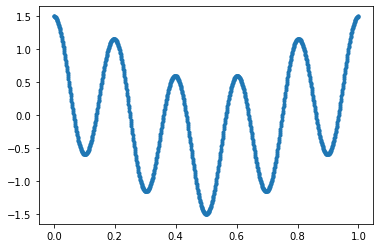

In [37]:
import numpy as np
import matplotlib.pyplot as plt

freq1 = 5.0      # freq in Hz
freq2 = 1.0      # freq in Hz
samp  = 1000.0   # sampling rate in Hz

t = np.arange(0,1,1/samp)  # time (1s of data)
N = len(t)                 # store the number of time points

x = np.cos(2*np.pi*freq1*t) + .5*np.cos(2*np.pi*freq2*t)  # the signal equation
plt.figure()
plt.plot(t,x,'.-')
plt.show()

Now remember: this signal is assumed by the FFT to be periodic, so even though it has finite duration, it will be treated by the FFT as if it were repeating, and therefore as if it were a true cosine function.

Let's see what happens when we take subsamples from this signal (make sure you understand all the code below):

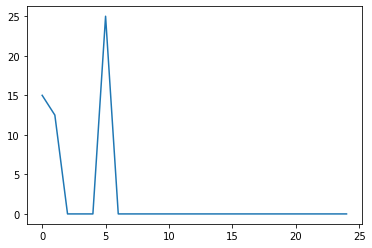

In [36]:
F = 50.0         # sub-sampling frequency (Hz)
T = 1/F          # sub-sampling period (sec)
n = int(N*T)     # sub-sampling period (in samples)

z = x[::n]         # sub-sampled signal
y = np.fft.fft(z)  # fft of sub-sampled signal

subN = len(z)  # length of sub-sampled signal


f = np.linspace(0,subN-1,subN)  # vector of frequencies for plotting

plt.plot(f[:subN//2], np.abs(y[:subN//2])) # plot powerspectrum as before
plt.show()

Now change the frequency of sub-sampling and see what happens to the fourier transform. 

You should be able to see that as soon as you drop below 10Hz, you loose the peak at 5Hz in the powerspectrum. 

Try to use the ifft function to reconstruct the signal from its fft and compare it to the almost continuous version. Example

------------------------------------------------------------------------------------------------------------------------------



# Filtering

Here we will implement a simple linear filter using convolution and the Fourier transform.

Recall that convolution in real space is the same as multiplication in Fourier space, and vice versa. But convolution is more difficult to implement than multiplication, so often it is a good idea to do a Fourier transform of the signal and of the filter, then multiply the two FFTs together, and then do an inverse FFT.

Let's first design a filter. We are going to do this in 2D, so load the cat image if you haven't done that yet.

Now let's create a "moving average" filter (also called the mean filter). This means a box that we are going to run through the image and take local averages.

In [32]:
siz = [3, 3]   # 3x3 box. You can play with changing this
box = np.ones(siz)/9

Now we could create a loop through all the image and for each pixel of the image replace the value by the weighted average within the small box. 

Instead, we are going to do this via a Fourier transform. 
First, let's calculate the Fourier transform of the image and the filter:

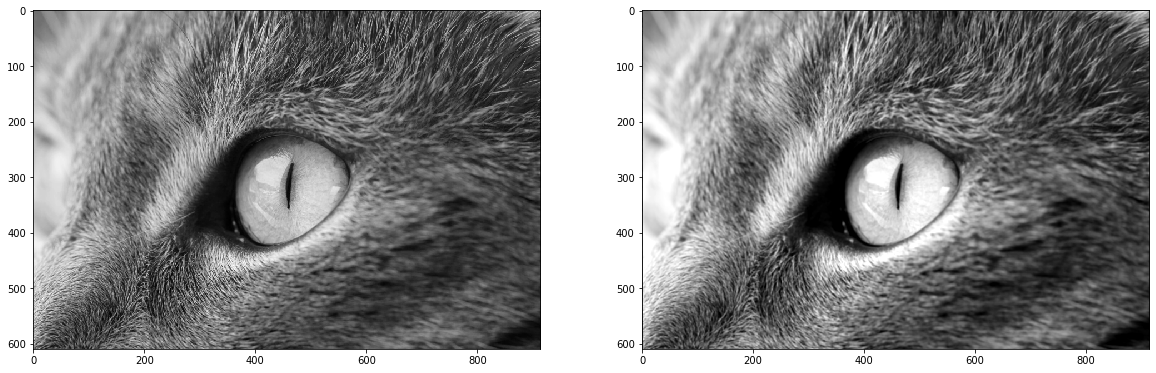

In [33]:
import matplotlib.image as mpimg 
import matplotlib.cm as cm 

dir='C:/Users/dario/Dropbox/Università/Digital_data_analysis/2020-2021/FFT_sampling/'
im = mpimg.imread(dir+'image.jpg')      # read image
#im = im[:,:,0]                    # only keep one colour channel
im = np.asarray(im,dtype='float') # convert to float 

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(im, cmap=cm.gray)


x = im
y = np.fft.fft2(x)
f = np.fft.fft2(box, s=x.shape)  # use zeropadding
z = np.fft.ifft2(y*f)  # inverse FFT of the product

clim = np.quantile(np.abs(z.reshape(-1)), [.01, .99])
plt.subplot(122)
plt.imshow(np.abs(z), vmin=clim[0], vmax=clim[1], cmap=cm.gray)
plt.show()

Let's now design another type of filter: an edge detection filter. The simplest such filter is to do a derivative, which in discrete terms is simply the difference between adjacent pixels.

Here are simple finite difference filters:

In [20]:
box = [[-1, 1]]          # along x-dimension
box = [[-1],[ 1]]        # along y-dimension
box = [[-1, 0, 1]]       # a slightly better filter along x
box = [[-1],[ 0],[ 1]]   # a slightly better filter along y

Now let's apply these filters to the cat image:

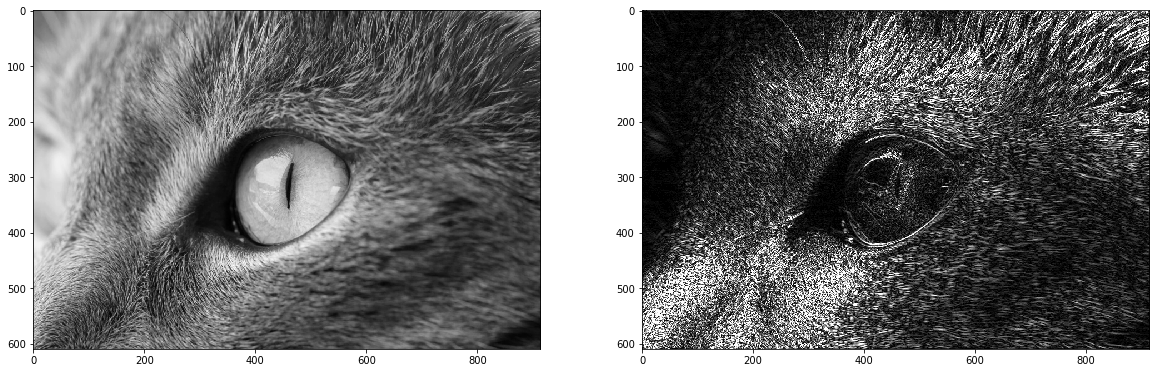

In [34]:
x = im
y = np.fft.fft2(x)


#box = [[-1, 1]]          # along x-dimension
box = [[-1],[ 1]]        # along y-dimension
#box = [[-1, 0, 1]]       # a slightly better filter along x
#box = [[-1],[ 0],[ 1]]   # a slightly better filter along y


f = np.fft.fft2(box, s=x.shape)  # use zeropadding
z = np.fft.ifft2(y*f)  # inverse FFT of the product

clim = np.quantile(np.abs(z.reshape(-1)), [.05, .95])


plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(im, cmap=cm.gray)
plt.subplot(122)
plt.imshow(np.abs(z), vmin=clim[0], vmax=clim[1], cmap=cm.gray)
plt.show()

You see edges along the x-dimension in the image (similarly along the y dimension if you used the y-derivative filter).

These types of operations are extremely widely used in image processing for extracting basic information from images.

Other types of filtering operations are also possible (such as non-linear filters), but these can't be implemented with the Fourier transform.